# MODULE 1: TIME SERIES SEGMENTATION USING GMMs

# Import required packages

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime

# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

# Data Preprocessing

In [19]:
#Loading the dataset
df =  pd.read_csv('owid-covid-data_1_may.csv', encoding = 'utf8')
countries = ['Australia', 'Switzerland', 'China', 'India', 'Iceland',
       'South Korea', 'New Zealand','Austria'] #unordered list of countries
df = df[df['countriesAndTerritories'].isin(countries)]
df.head()

,geoId,countriesAndTerritories,dateRep,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
673,AUS,Australia,31-12-2019,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
674,AUS,Australia,01-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
675,AUS,Australia,02-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
676,AUS,Australia,03-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
677,AUS,Australia,04-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


### Converting the string of dates into datetime object and trimming cases with 0 confirmed cases from the beginning of the data

In [20]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%d-%m-%Y')
    return datetime_object.date()

Dates= df.apply(lambda row: date_conversion(row.dateRep), axis = 1)
df.insert(3,'Dates',Dates)
df.drop('dateRep',axis =1,inplace=True)
df_new = df[df['total_cases']>0].copy()
df_new.head()

,geoId,countriesAndTerritories,Dates,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
698,AUS,Australia,2020-01-25,1,1,0,0,0.039,0.039,0.0,0.0,NaN,NaN,NaN,NaN,NaN
699,AUS,Australia,2020-01-26,4,3,0,0,0.157,0.118,0.0,0.0,NaN,NaN,NaN,NaN,NaN
700,AUS,Australia,2020-01-27,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
701,AUS,Australia,2020-01-28,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
702,AUS,Australia,2020-01-29,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## Getting the cumulative number of days

In [21]:
country_list = list(df['countriesAndTerritories'].unique()) #to ensure the order of the countries
def get_first_day(country_list,df):
    f_day = []
    for i in country_list:
        first_day = df.loc[df[df['countriesAndTerritories']==i].index[0]].Dates
        f_day.append(first_day)
    return f_day
first_occurence = get_first_day(country_list, df_new)

def cumulative_day(country, Dates, first_occurence,country_list):
    val = (Dates - first_occurence[country_list.index(country)]).days + 1
    return val

In [22]:
# cum_day('China',first_occurence[0],first_occurence, country_list)
cum_day = df_new.apply(lambda row: cumulative_day(row.countriesAndTerritories,row.Dates,first_occurence, country_list), axis = 1)
df_new.insert(3, 'cum_day',cum_day)
df_new.head()

,geoId,countriesAndTerritories,Dates,cum_day,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
698,AUS,Australia,2020-01-25,1,1,1,0,0,0.039,0.039,0.0,0.0,NaN,NaN,NaN,NaN,NaN
699,AUS,Australia,2020-01-26,2,4,3,0,0,0.157,0.118,0.0,0.0,NaN,NaN,NaN,NaN,NaN
700,AUS,Australia,2020-01-27,3,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
701,AUS,Australia,2020-01-28,4,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
702,AUS,Australia,2020-01-29,5,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [23]:
#Removing the abonormal datapoint for China
df_new.drop(df_new[(df_new['countriesAndTerritories']=='China') & (df_new['cases']==15141)].index, axis = 0, inplace=True)

# EDA

In [24]:
#Generates the bar plot of number of cases
def barplot(country):
    plt.figure(figsize=(16,8))
    ax= sns.barplot(x= "cum_day", y = "cases", data = df_new[df_new['countriesAndTerritories']==country],palette='binary_r')
    ax.set(xlabel='Days', ylabel='Number of incoming cases')
    plt.title('Barplot of '+ country)

#     plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' barplot.png',dpi = 500)

    plt.show()

In [25]:
#Generates the distplot of the number of cases
def distplot(country):
    plt.figure(figsize=(16,8))
    ax = sns.distplot(df_new[df_new['countriesAndTerritories']==country].cases,color='k')
    ax.set(xlabel = 'Cases', ylabel = 'Proportion')
    plt.title('Distplot of '+ country)

#     plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' distplot.png',dpi = 500)
    plt.show()

# Model Selection

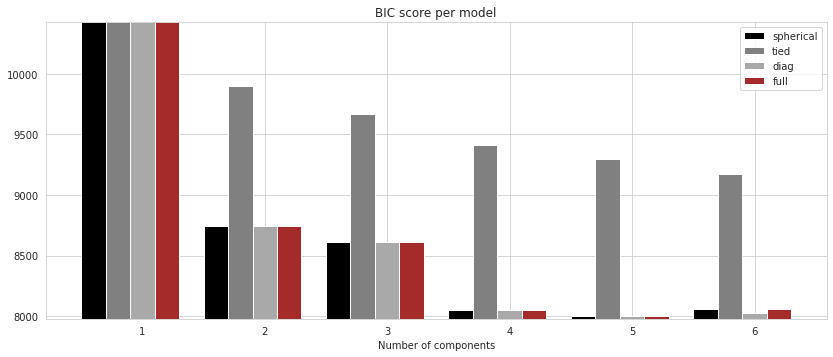

In [26]:
#Vary the number of components and the covariance type to get the get fit
cases_counts = df_new.cases
day = df_new.cum_day
X = np.reshape(np.array(cases_counts),(-1,1))
np.random.seed(0)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
#covariance type
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['black', 'grey', 'darkgrey',
                              'brown'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(14,12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [27]:
#To plot the result of the code. Gives the counts of daily incoming cases color coded with the stage they belong to. If called
def plot_results(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df_new[df_new['countriesAndTerritories']==country].cum_day,df_new[df_new['countriesAndTerritories']==country].cases,
            c=df_new[df_new['countriesAndTerritories']==country].Stages)
    plt.title('Day-wise Counts and Stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Counts')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
#     plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ ' +country+' counts and stages.png',dpi = 500)
    plt.show()


In [28]:
#Generates the Cluster vs Stages if called
def clustervsstages(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df_new[df_new['countriesAndTerritories']==country].cum_day,df_new[df_new['countriesAndTerritories']==country].Stages,
            c=df_new[df_new['countriesAndTerritories']==country].Stages)
    plt.title('Day-wise stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
#     plt.savefig('D:\Studies\Corona Research\Plots\Daywise Stages\ ' +country+' daywise stages.png',dpi = 500)
    plt.show()


# Determining the outbreak

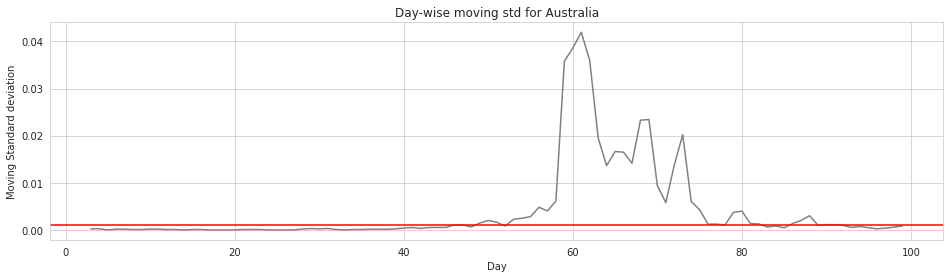

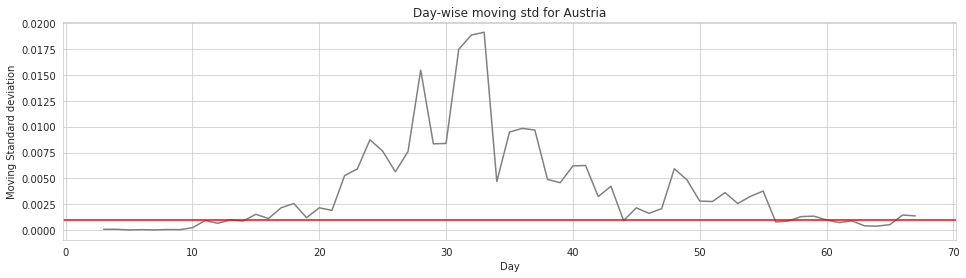

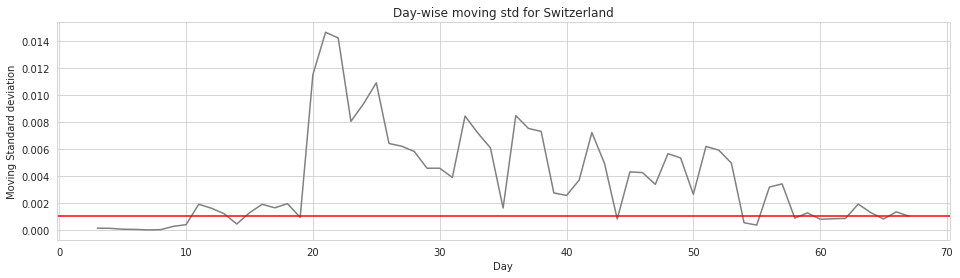

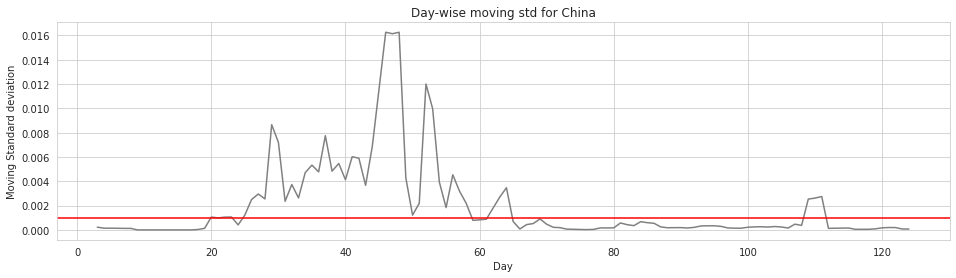

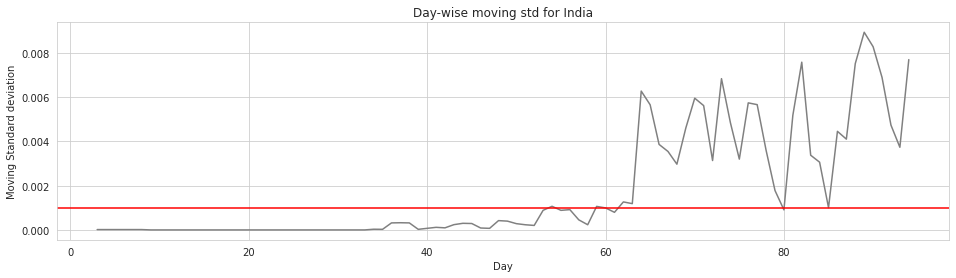

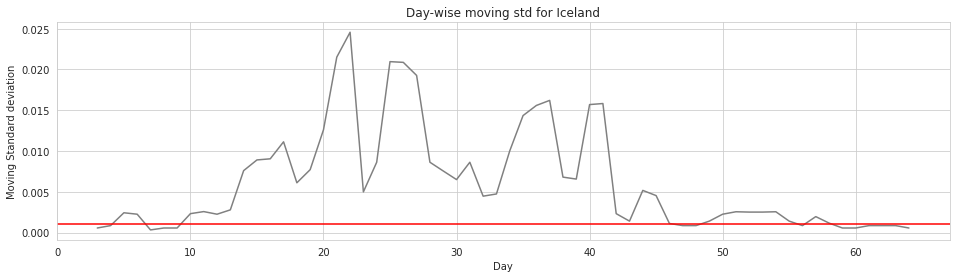

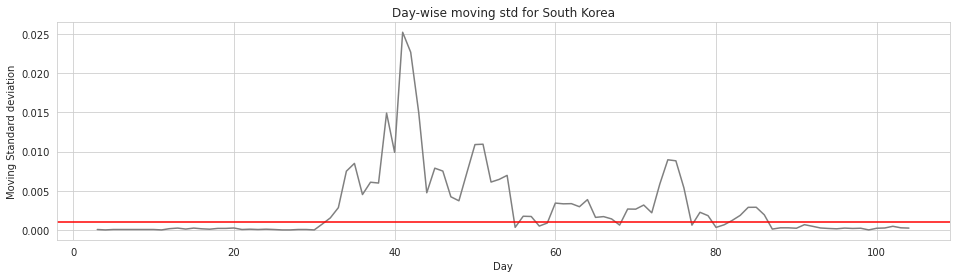

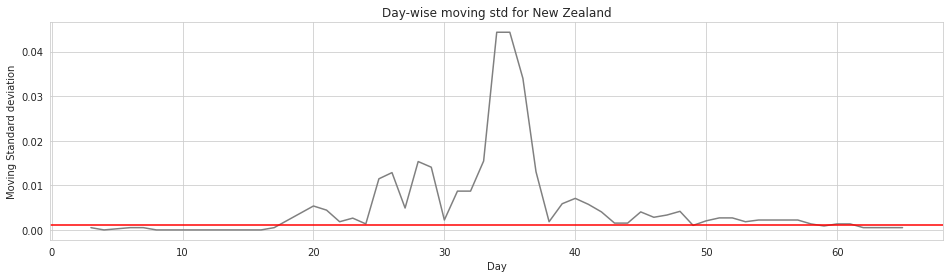

In [29]:
df_std = df_new.copy()
rol = []
#To scale the data
for item in country_list:
    normalised_std = df_std[df_std['countriesAndTerritories']==item].cases/(df_std[df_std['countriesAndTerritories']==item].cases.sum())
# Used to get moving standard deviation
    rol.extend(normalised_std.rolling(3).std())
#Add a column as rolling std
df_std['rolling_std']=rol
df_std.drop(df_std[df_std.rolling_std.isna()==True].index,inplace=True)
#Generates country wise plot to visualise the threshold for determining the outbreak
for item in country_list:
    plt.figure(figsize=(16,4))
    plt.plot(df_std[df_std['countriesAndTerritories']==item].cum_day,df_std[df_std['countriesAndTerritories']==item].rolling_std,color='grey')
    plt.title('Day-wise moving std for '+item) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Moving Standard deviation')
    plt.axhline(y=0.001,color='r')
#     cbar = plt.colorbar()
#     cbar.set_label('Stages')
    plt.savefig('D:\Studies\Corona Research\Plots\Dev_ins\ ' +item+' moving std.png',dpi = 500)
    plt.show()

In [30]:
#Filtering the data based on the threshold for the outbreak
df_training = df_std[df_std['rolling_std']>=0.000]
#Determines the cumulative day since outbreak
df_training.drop(['cum_day'],axis =1,inplace=True)
days_since_outbreak = df_training.apply(lambda row: cumulative_day(row.countriesAndTerritories,row.Dates,get_first_day(country_list, df_training), country_list), axis = 1)
df_training.insert(3, 'days_outbreak',days_since_outbreak)

In [31]:
#Function to fit GMM and Poisson Mixture Model and generate the components
def groupby_generator(n_mixtures,df):
    data_list = []

    input_data =  np.reshape(np.array(df.cases),(-1,1))
    input_data_gmm = pd.concat([df.days_outbreak, df.cases], axis =1)
    gmm = mixture.GaussianMixture(n_components=n_mixtures,covariance_type='full')
    gmm.fit(input_data_gmm)
    means=gmm.means_
    d1 = PoissonDistribution(means[0][1])
    d2 = PoissonDistribution(means[1][1])
    d3 = PoissonDistribution(means[2][1])
    d4 = PoissonDistribution(means[3][1])
    model = GeneralMixtureModel([d1,d2,d3,d4])
    model.fit(input_data)
    return model

#Generated output based on the trained model
def output_generator(n_mixtures,model,input_data):
    
    sequence = model.predict(input_data)
    unique_elements, counts_elements = np.unique(sequence, return_counts=True)
    model.clear_summaries()
    para = []
    for i in range(n_mixtures):
        para.append(model.distributions[i].parameters)

#for getting the stages based on the components             
        
    rank = rankdata(para, method='ordinal')
    stages = []
    for _ in range(len(sequence)):
        if sequence[_]==0:
            stages.append(rank[0])
            continue
        elif sequence[_]==1:
            stages.append(rank[1])
            continue
        elif sequence[_]==2:
            stages.append(rank[2])
            continue
        else:
            stages.append(rank[3])
        
    data_list = [(para),list(zip(unique_elements,counts_elements)),stages, sequence]
#     dicti[country_list[j]] =data_list
    return data_list


In [32]:
#Groupby based on days since outbreak to train the generalised model
df_training = df_training[~df_training['countriesAndTerritories'].isin(['India'])].groupby(['days_outbreak']).sum()
df_training.reset_index(inplace=True)
trained_model = groupby_generator(4,df_training)
prediction_data_group =  np.reshape(np.array(df_training.cases),(-1,1))
output_data_group = output_generator(4,trained_model,prediction_data_group)
df_training['Stages_g']=output_data_group[2]


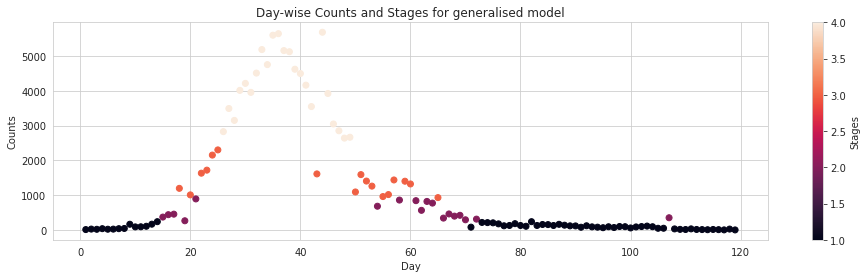

In [33]:
#To plot the result of the code. Gives the counts of daily incoming cases color coded with the stage they belong to.
plt.figure(figsize=(16,4))
plt.scatter(df_training[:-3].days_outbreak,df_training[:-3].cases,
            c=df_training[:-3].Stages_g,)
plt.title('Day-wise Counts and Stages for generalised model') #to undestand the number of components which can be used
plt.xlabel('Day')
plt.ylabel('Counts')
cbar = plt.colorbar()
cbar.set_label('Stages')
plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ '+'generalised'+' counts and stages.png',dpi = 500)
plt.show()


# MODULE 2: MARKOV MODEL PROVIDE STAGES

In [34]:
def transition_matrix(arr, n=1):
    """"
    Computes the transition matrix from Markov chain sequence of order `n`.

    :arr: Discrete Markov chain state sequence in discrete time with states in 0, ..., N
    :param n: Transition order
    """

    M = np.zeros(shape=(max(arr) , max(arr) ))
    for (i, j) in zip(arr, arr[1:]):
        M[i-1, j-1] += 1

    T = (M.T / M.sum(axis=1)).T

    return np.linalg.matrix_power(T, n)

In [35]:
tpm_group = transition_matrix(df_training.Stages_g)

In [36]:
tpm_group

array([[0.95238095, 0.04761905, 0.        , 0.        ],
       [0.16666667, 0.5       , 0.33333333, 0.        ],
       [0.        , 0.35294118, 0.52941176, 0.11764706],
       [0.        , 0.        , 0.08695652, 0.91304348]])

In [37]:
np.linalg.matrix_power(tpm_group,30)

array([[0.5864777 , 0.14537683, 0.12739739, 0.14074808],
       [0.50881892, 0.14963725, 0.14306749, 0.19847634],
       [0.47211974, 0.15148322, 0.1503386 , 0.22605844],
       [0.38552734, 0.15532931, 0.16708668, 0.29205667]])

In [38]:
np.linalg.matrix_power(tpm_group,50)

array([[0.54143028, 0.14771825, 0.13638303, 0.17446844],
       [0.51701388, 0.14894581, 0.14122011, 0.1928202 ],
       [0.50541946, 0.14952718, 0.14351581, 0.20153755],
       [0.47789182, 0.15090277, 0.14896254, 0.22224288]])

In [39]:
#Given a TPM and initial state, helps to get the first passage time
def first_passage_time(tpm,init_state):
    step_1 = np.delete(tpm,init_state-1,1)
    step_2 = np.delete(step_1,init_state-1,0)
    a = step_2-np.identity(step_1.shape[1])
    b = -1*np.ones(step_2.shape[0])
    val = np.linalg.solve(a,b)
    return val
    
    

In [40]:
first_passage_time(tpm_group,1)

array([19.33333333, 26.        , 37.5       ])

In [41]:
first_passage_time(tpm_group,2)

array([21.        ,  6.66666667, 18.16666667])

In [42]:
first_passage_time(tpm_group,3)

array([34.5, 13.5, 11.5])

In [43]:
first_passage_time(tpm_group,4)

array([83.5, 62.5, 49. ])

In [44]:
df_seq = df_std[df_std['rolling_std']>=0.000]

In [45]:
#Generating data with stages as output. These stages are used by module 3 for further forecasting.
stage = []
for item in country_list:
    val = df_seq[df_seq['countriesAndTerritories']==item].cases
    pred =  np.reshape(np.array(val),(-1,1))
    output = output_generator(4,trained_model,pred)
    stage.extend(output[2])
df_seq['Stages'] = stage

In [47]:
print(df_seq.geoId.unique())

['AUS' 'AUT' 'CHE' 'CHN' 'IND' 'ISL' 'KOR' 'NZL']


In [48]:
df_seq = df_seq[df_seq['geoId'].isin(['IND'])]

In [49]:
df_seq = df_seq[['geoId','Dates', 'Stages']]

In [51]:
df_seq.to_csv('Stages.csv')

# MODULE 3.1:  SIR Model For Baseline Predictions

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
from sklearn.linear_model import Ridge
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

#Loading the dataset
df =  pd.read_csv('time_series.csv', encoding = 'utf8')

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%d-%m-%Y')
    return datetime_object.date()

df['Date']= df.apply(lambda row: date_conversion(row.Date), axis = 1)

def get_first_day(df):
    return df.loc[0].Date
first_occurence = get_first_day(df)
def cumulative_day(Dates,first_occurence):
    val = (Dates-first_occurence).days + 1
    return val

# cum_day('China',first_occurence[0],first_occurence, country_list)
df['cum_day'] = df.apply(lambda row: cumulative_day(row.Date,first_occurence), axis = 1)
# df_new.insert(3, 'cum_day',cum_day)
threshold = 6
df['infected_t'] = df['Total Confirmed'] - df['Total Recovered'] - df['Total Deceased']
df_beta = df[df['Total Confirmed']<threshold]
df = df[df['Total Confirmed']>=threshold]
# print(df_beta.tail())


In [55]:
def cal_parameters(data):
    data['beta_t']=(-data['infected_t'].diff(periods=-1)  - data['Total Recovered'].diff(periods=-1)-
                    data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['beta_t']<0]['beta_t']=0
    data['gamma_t'] = (- data['Total Recovered'].diff(periods=-1))/((data['infected_t']))
    data[data['gamma_t']<0]['gamma_t']=0.0769
    data['mu_t'] = (- data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['mu_t']<0]['mu_t']=0
    return data


In [56]:
df= cal_parameters(df)
df_beta = cal_parameters(df_beta)

In [57]:
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,cum_day,infected_t,beta_t,gamma_t,mu_t
33,2020-03-03,1,6,0,3,0,0,34,3,7.333333,-0.0,-0.0
34,2020-03-04,22,28,0,3,0,0,35,25,0.080000,-0.0,-0.0
35,2020-03-05,2,30,0,3,0,0,36,27,0.037037,-0.0,-0.0
36,2020-03-06,1,31,0,3,0,0,37,28,0.107143,-0.0,-0.0
37,2020-03-07,3,34,0,3,0,0,38,31,0.161290,-0.0,-0.0


In [58]:
med_gamma= df.gamma_t.median()
med_beta = df.beta_t.median()
med_mu = df.mu_t.median()

In [59]:
df['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
df_beta['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df_beta['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df_beta['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
max_val_pred = len(df)

In [60]:
def FIR_filter(statistic,order,a):
    window = order +1
    slide = np.array([statistic[i:i+window] for i in range(len(statistic)-window+1)])
    training_x = slide[:,:-1]
    training_y = slide[:,-1]
    clf = Ridge(alpha = a)
    clf.fit(training_x,training_y)
    return clf

In [61]:
#start date should be greater than the first value in the dataframe. 
def sir_generator_backward(data,start_date,predict_range,window_size):
    start = date_conversion(start_date)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    clf_beta = FIR_filter(list(data.beta_t[:-2]),window_size,0.03)
    clf_gamma =  FIR_filter(list(data.gamma_t[:-2]),window_size,1e-6)
    clf_mu = FIR_filter(list(data.mu_t[:-2]),window_size,0.01)
    if (end <= last_existing_date):
        #data already exists.. to check accuracy of the model
        beta_pred = list(df_beta.beta_t[:-2])[-window_size:]
        bg_dates = list(df_beta.Date[:-2])[-window_size:]
        gamma_pred = list(df_beta.gamma_t[:-2])[-window_size:]
        mu_pred = list(df_beta.mu_t[:-2])[-window_size:]
        x_t_hat = []
        xr_dates = []
        r_t_hat = []
        d_t_hat = []
        val = []
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            r_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Recovered'].item())+
                            (gamma_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            d_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Deceased'].item())+
                            (mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Out of Range')
        

In [62]:
#Should be 14 May,2020 or next date to where the data ends.
def sir_generator_forward(data,start_date,predict_range,window_size):
    start = date_conversion(start_date)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    clf_beta = FIR_filter(list(data.beta_t[:-2]),window_size,0.03)
    clf_gamma =  FIR_filter(list(data.gamma_t[:-2]),window_size,1e-6)
    clf_mu = FIR_filter(list(data.mu_t[:-2]),window_size,0.01)
    if (start > last_existing_date):
        #data already exists.. to check accuracy of the model
        beta_pred = list(data.beta_t[:-2])[-window_size:]
        bg_dates = list(data.Date[:-2])[-window_size:]
        gamma_pred = list(data.gamma_t[:-2])[-window_size:]
        mu_pred = list(data.mu_t[:-2])[-window_size:]
        x_t_hat = [list(data.infected_t)[-1]]
        xr_dates = [list(data.Date)[-1]]
#         print(type(x_t_hat))
        r_t_hat = [list(data['Total Recovered'])[-1]]
        d_t_hat = [list(data['Total Deceased'])[-1]]
        val = []
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(x_t_hat[-1]))
            r_t_hat.append((r_t_hat[-1])+(gamma_pred[-1])*(x_t_hat[-1]))
            d_t_hat.append((d_t_hat[-1])+(mu_pred[-1])*(x_t_hat[-1]))
        
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Please call SIR_Generator Backward function')
        

In [63]:
df_b_ldown = df[df['Total Confirmed']<=497].copy()
wl_d, wl_x,wl_r,wl_d = sir_generator_forward(df_b_ldown,'24-03-2020',30,14)
w_l_pred = pd.DataFrame(list(zip(wl_d,wl_x,wl_r,wl_d)), columns = ['Dates','Xt','Rt','Dt'])


In [64]:
a,b,c,d = sir_generator_backward(df,'04-03-2020',70,14)

In [65]:
e,f,g,h = sir_generator_forward(df,'14-05-2020',200,14)

In [66]:
trial =pd.DataFrame(list(zip(a,b,c,d)),columns=['Dates','Xt','Rt','Dt'])
trial_1 = pd.DataFrame(list(zip(e,f,g,h)),columns=['Dates','Xt','Rt','Dt'])
trial_2 = pd.concat([trial,trial_1],ignore_index=True)

70

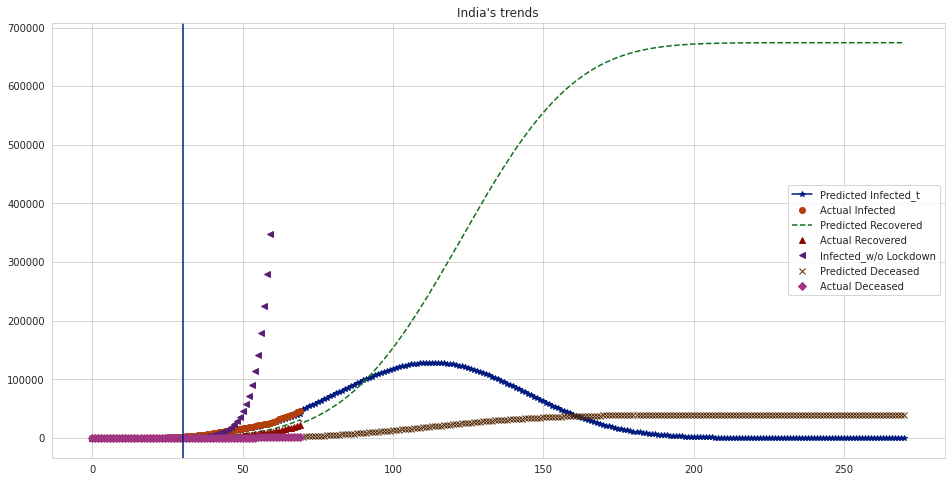

In [67]:
# trial = pd.DataFrame(a,columns=['Date','Infect'])
x_data = range(60)
plt.figure(figsize=(16,8))
line_1, = plt.plot(trial_2.Xt,marker = '*')
line_2, = plt.plot(list(df.iloc[:70].infected_t),'o')
line_3, = plt.plot(trial_2.Rt,'--')
line_4, = plt.plot(list(df.iloc[:70]['Total Recovered']),'^')
line_5, = plt.plot(x_data[30:],w_l_pred.iloc[1:].Xt,'<')
line_6, = plt.plot(trial_2.Dt,'x')
line_7, = plt.plot(list(df.iloc[:70]['Total Deceased']),'D')
plt.legend([line_1,line_2,line_3,line_4,line_5,line_6,line_7],
           ['Predicted Infected_t','Actual Infected','Predicted Recovered','Actual Recovered','Infected_w/o Lockdown',
           'Predicted Deceased','Actual Deceased'] )
plt.axvline(x=30)
plt.title("India's trends")
plt.savefig('pred_india.png')
# trial
len(list(df.iloc[2:79].infected_t))

In [68]:
trial_2.to_csv('Predicted_SIR.csv')

# MODULE 3.2:  POISSON REGRESSION: (SIR Predictions + Other Factor)

##  OVERVIEW

This notebook consist of the <b> Forecasting Module </b> of our Solution, This will consider the data from different sources, including the output of the <b> Markov Module </b> i.e the Stages at which a country is in a particular year. This notebook consist of following 6 Sections: 

<b> 1) Importing Packages  </b> <br> 
<b> 2) Loading Datasets and Preprocessing Steps  </b> <br>
<b> 3) ACF and PACF Plots for determine appropriate Lag  </b> <br> 
<b> 4) Data Visualization </b> <br>
<b> 5) Defining Utility Function for Data Modelling </b> <br>
<b> 6) Model Fitting and Results  </b> <br> 






## 1. IMPORTING PACKAGES

In [7]:
# Importing Packages

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error

## 2. LOADING DATASETS AND PREPROCESSING STEPS 

In [15]:
# Reading the dataset

#India = pd.read_csv('../Data/12th May/India_final.csv')
SIR = pd.read_csv('Predicted_SIR.csv')
stages = pd.read_csv('Stages.csv')

In [16]:
SIR.head()

,Unnamed: 0,Dates,Xt,Rt,Dt
0,0,2020-03-04,2.339038,3.947208,0.011924
1,1,2020-03-05,25.942126,5.047918,0.099735
2,2,2020-03-06,29.437464,3.640227,0.108006
3,3,2020-03-07,22.950189,11.138750,0.112205
4,4,2020-03-08,31.579447,5.789591,0.125115


In [17]:
stages.head()

,Unnamed: 0,geoId,Dates,Stages
0,6318,IND,2020-02-01,1
1,6319,IND,2020-02-02,1
2,6320,IND,2020-02-03,1
3,6321,IND,2020-02-04,1
4,6322,IND,2020-02-05,1


In [315]:
India.govt_pol_index.fillna(0.7, inplace=True)
India.tests_per_thous.fillna(0.07, inplace=True)

In [316]:
India.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             218 non-null    object 
 1   location         218 non-null    object 
 2   new_cases        70 non-null     float64
 3   new_deaths       70 non-null     float64
 4   total_cases      70 non-null     float64
 5   total_deaths     70 non-null     float64
 6   govt_pol_index   218 non-null    float64
 7   tests_per_thous  218 non-null    float64
 8   Susceptible      218 non-null    float64
 9   Infected         218 non-null    float64
 10  Recovered        218 non-null    float64
 11  I_x              218 non-null    float64
 12  Stages           218 non-null    int64  
 13  Xt               218 non-null    float64
 14  Rt               218 non-null    float64
dtypes: float64(12), int64(1), object(2)
memory usage: 25.7+ KB


In [317]:
def adding_lagged_values(df, lag):
    data = list(df['govt_pol_index'])
    lagged_data = []
    for i in range(lag):
        lagged_data.append(0)
    for i in range(lag, len(data)):
        lagged_data.append(data[i-lag])
    df['lagged_gov_pol_index'] = lagged_data
    df.reset_index()
    return(df)
# print(np.round(lagged_data, 2))

In [318]:
India = adding_lagged_values(India, 21)

In [10]:
def normalize_sig(df):
    df['norm_cases'] = df['new_cases']/np.std(df['new_cases'])
    df['norm_tests'] = df['tests_per_thous']/np.std(df['tests_per_thous'])
    df['norm_Gov'] = df['lagged_gov_pol_index']/np.std(df['lagged_gov_pol_index'])
    df['norm_deaths'] = df['new_deaths']/np.std(df['new_deaths'])
    df['norm_Ix'] = df['I_x']/np.std(df['I_x'])
    df['norm_Xt'] = df['Xt']/np.std(df['Xt'])
    df['norm_Rt'] = df['Rt']/np.std(df['Rt'])
    return(df)

In [11]:
India_norm = normalize_sig(India)

In [12]:
India_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  218 non-null    object 
 1   location              218 non-null    object 
 2   new_cases             70 non-null     float64
 3   new_deaths            70 non-null     float64
 4   total_cases           70 non-null     float64
 5   total_deaths          70 non-null     float64
 6   govt_pol_index        218 non-null    float64
 7   tests_per_thous       218 non-null    float64
 8   Susceptible           218 non-null    float64
 9   Infected              218 non-null    float64
 10  Recovered             218 non-null    float64
 11  I_x                   218 non-null    float64
 12  Stages                218 non-null    int64  
 13  Xt                    218 non-null    float64
 14  Rt                    218 non-null    float64
 15  lagged_gov_pol_index  2

In [13]:
India.describe()

,new_cases,new_deaths,total_cases,total_deaths,govt_pol_index,tests_per_thous,Susceptible,Infected,Recovered,I_x,...,Xt,Rt,lagged_gov_pol_index,norm_cases,norm_tests,norm_Gov,norm_deaths,norm_Ix,norm_Xt,norm_Rt
count,70.000000,70.00000,70.000000,70.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,70.000000,218.000000,218.000000,70.000000,218.000000,218.000000,218.000000
mean,1061.085714,34.50000,15957.928571,517.385714,26.190092,0.405927,110227.289675,59044.939162,130730.771163,1370.589221,...,45793.461877,299617.829402,26.122661,0.898021,1.222606,0.650944,0.852580,0.626159,0.973524,1.064293
std,1190.114180,40.75759,20779.737339,687.487935,40.179293,0.332782,127944.370614,52214.236304,111259.280650,2193.922992,...,47147.112286,282165.994721,40.222779,1.007220,1.002301,1.002301,1.007220,1.002301,1.002301,1.002301
min,1.000000,0.00000,6.000000,0.000000,0.700000,0.000000,1146.481584,62.687421,13.380712,8.000000,...,2.331985,3.640227,0.000000,0.000846,0.000000,0.000000,0.000000,0.003655,0.000050,0.000013
25%,57.250000,1.00000,349.750000,4.750000,0.700000,0.033500,2334.653586,16709.970520,4193.266972,30.893251,...,2970.070617,9838.909998,0.700000,0.048452,0.100898,0.017443,0.024712,0.014114,0.063141,0.034949
50%,685.500000,25.00000,5464.000000,157.500000,0.700000,0.700000,20794.121281,42956.571197,135328.929111,178.326921,...,24415.131298,220262.173070,0.700000,0.580154,2.108323,0.017443,0.617811,0.081469,0.519042,0.782409
75%,1550.500000,49.75000,25998.500000,811.750000,53.300000,0.700000,276264.412778,100504.738832,246023.017289,1644.589576,...,88933.576113,626636.803250,53.300000,1.312223,2.108323,1.328170,1.229445,0.751337,1.890641,2.225920
max,4213.000000,195.00000,74281.000000,2415.000000,100.000000,0.700000,299926.931868,159096.979991,282589.443019,7532.496874,...,131762.185730,683902.426013,100.000000,3.565556,2.108323,2.491875,4.818930,3.441248,2.801135,2.429337


## 4. DATA VISUALIZATION

In [14]:
# Plotting the Confirmed Cases with Date
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(df, label1):
    sns.set(rc = {'figure.figsize':(11,4)})
    df[label1].plot(linewidth = 3, color = 'purple')
    #df[label2].plot(linewidth = 3, color = 'red')

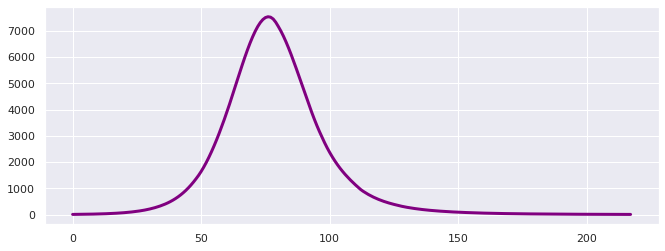

In [15]:
plot_data(India, 'I_x')

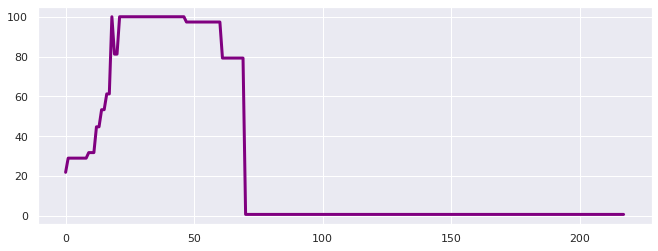

In [16]:
plot_data(India, 'govt_pol_index')

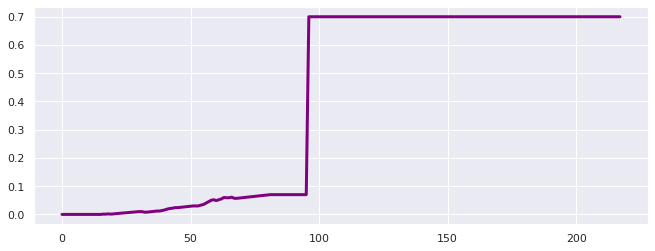

In [17]:
plot_data(India, 'tests_per_thous')

In [18]:
#India = India.head(102)

## PLOTTING THE CORRELATION GRAPH

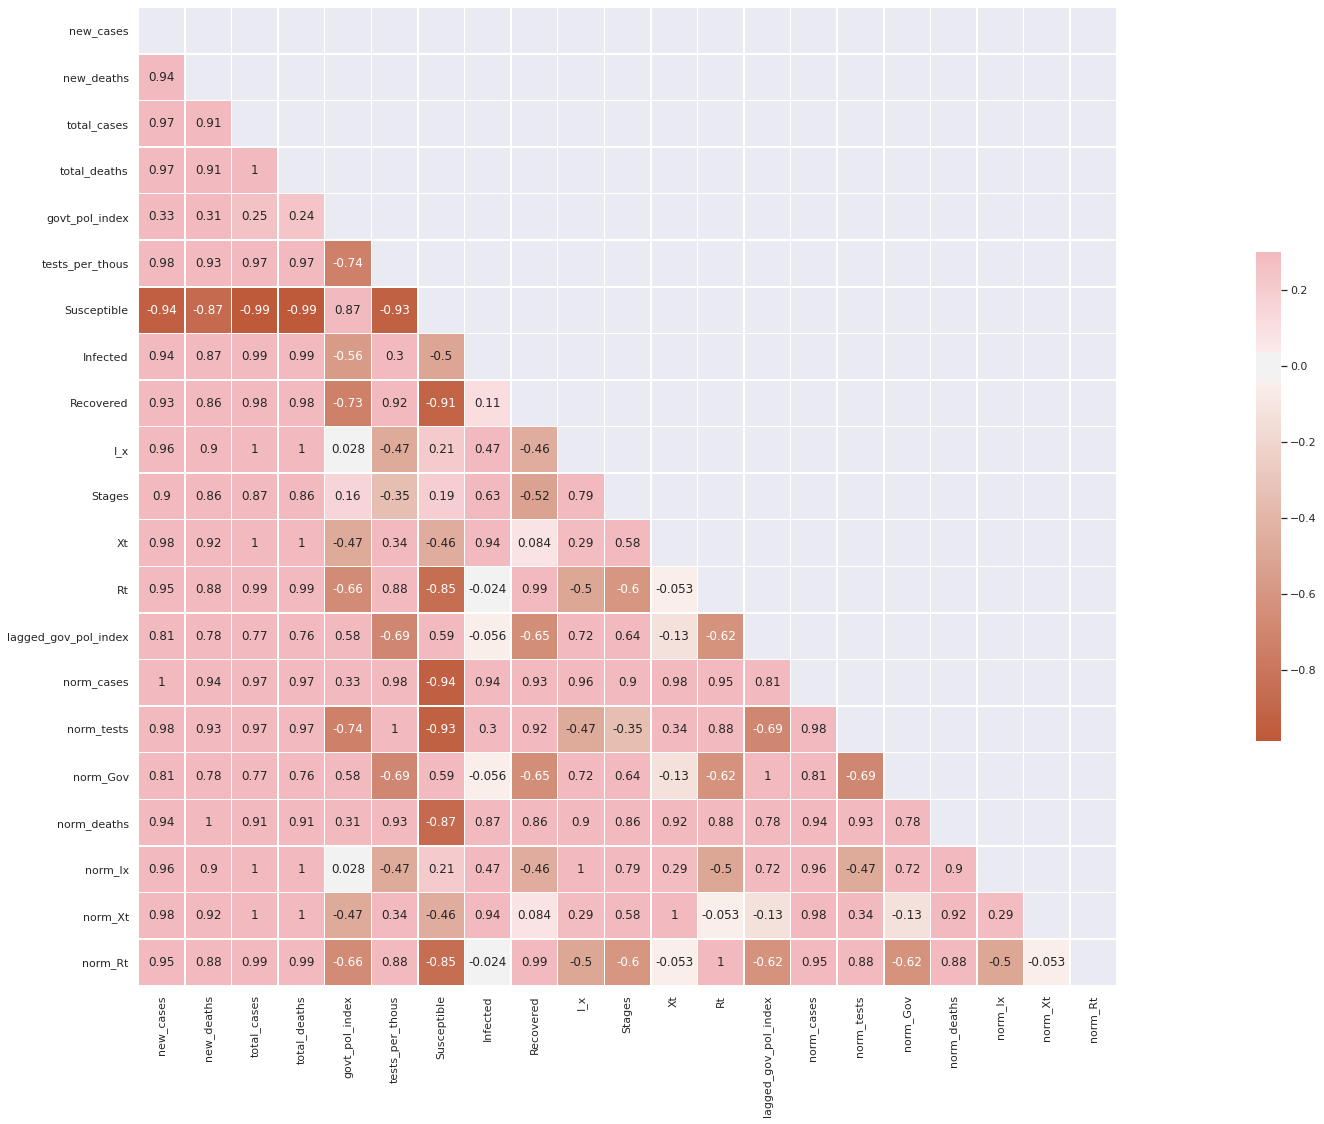

In [19]:
# Compute the correlation matrix
corr = India.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
India.set_index('Date')

,location,new_cases,new_deaths,total_cases,total_deaths,govt_pol_index,tests_per_thous,Susceptible,Infected,Recovered,...,Xt,Rt,lagged_gov_pol_index,norm_cases,norm_tests,norm_Gov,norm_deaths,norm_Ix,norm_Xt,norm_Rt
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,India,1.0,0.0,6.0,0.0,21.83,0.0,299926.931868,62.687421,13.380712,...,2.331985,3.947208,0.0,0.000846,0.000000,0.000000,0.0,0.003915,0.000050,0.000014
2020-03-05,India,22.0,0.0,28.0,0.0,28.97,0.0,299918.361463,69.805469,14.833068,...,25.881935,5.047918,0.0,0.018619,0.000000,0.000000,0.0,0.004365,0.000550,0.000018
2020-03-06,India,1.0,0.0,29.0,0.0,28.97,0.0,299908.806239,77.741395,16.452367,...,29.409238,3.640227,0.0,0.000846,0.000000,0.000000,0.0,0.004867,0.000625,0.000013
2020-03-07,India,2.0,0.0,31.0,0.0,28.97,0.0,299898.153124,86.589086,18.257790,...,22.916214,11.138750,0.0,0.001693,0.000000,0.000000,0.0,0.005424,0.000487,0.000040
2020-03-08,India,3.0,0.0,34.0,0.0,28.97,0.0,299886.279576,96.450296,20.270128,...,31.552933,5.789591,0.0,0.002539,0.000000,0.000000,0.0,0.006042,0.000671,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,India,NaN,NaN,NaN,NaN,0.70,0.7,1179.781420,17723.996313,281099.222266,...,375.715681,683711.087513,0.7,NaN,2.108323,0.017443,NaN,0.003933,0.007987,2.428658
2020-10-04,India,NaN,NaN,NaN,NaN,0.70,0.7,1171.173332,17348.173780,281483.652888,...,330.028629,683768.147265,0.7,NaN,2.108323,0.017443,NaN,0.003842,0.007016,2.428860
2020-10-05,India,NaN,NaN,NaN,NaN,0.70,0.7,1162.764656,16980.200295,281860.035049,...,289.387800,683818.611871,0.7,NaN,2.108323,0.017443,NaN,0.003758,0.006152,2.429040


## 5. DEFINITION OF UTILITY FUNCTIONS FOR MODELLING DATA

In [461]:
expr = """ new_cases ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt"""
expr_new = """new_cases ~ tests_per_thous"""
expr_new_1 = """new_cases ~ I_x"""
expr0 = """ new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index"""
expr1 = """ new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt"""
expr2 = """ new_deaths ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt"""
expr3 = """ new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index"""
expr4 = """ new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt"""
norm_expr = """ norm_cases ~ norm_tests + norm_Gov + norm_Xt + norm_Rt """
norm_expr0 = """ norm_cases ~ norm_Ix + norm_tests + norm_Gov + norm_Xt + norm_Rt """
norm_expr1 = """ norm_cases ~ norm_Ix + Stages + norm_tests + norm_Gov + norm_Xt + norm_Rt """

def train_test_split(df,ratio, expr):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

#     # Expression for the Model 
#     expr1 = """ cases cases ~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr2 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr3 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests + popData2018"""

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

    
def train_test_future_split(df, expr):
    df_train = df.head(70)
    df_test = df
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

#     # Expression for the Model 
#     expr1 = """ cases cases ~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr2 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr3 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests + popData2018"""

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

def train_model(y_train, X_train):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    print(model.summary())
    return(model)

def predict(model, X_test):
    poisson_predictions = model.get_prediction(X_test)
    #.summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    return(predictions_summary_frame['mean'])
    
    
def plot_results(predictions_summary_frame,X_test, y_test, country, label):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label]
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)

def plot_results_1(predictions_summary_frame, X_test, y_test, country, label1, label2):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label1]
    I_x = X_test[label2]
    avg = 0.5*predicted_counts + 0.5*X_test[label2] 
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    SIR, = plt.plot(X_test.index, I_x, 'bo-', label='SIR Predictions')
    Wt_predictions, = plt.plot(X_test.index, avg, 'yo-',label = 'Weighted Predictions')
    plt.legend(handles=[predicted, actual, SIR, Wt_predictions])
    plt.show()
    return(predicted_counts, actual_counts)
    
def plot_actual_vs_output(predicted_counts, actual_counts):
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()

## 6. NEW CASES MODEL: TRAINING AND RESULTS

## STEP 1: TEST-TRAIN SPLIT

In [462]:
India_filtered = India_norm[India_norm['total_cases']>-1].fillna(0)

In [463]:
X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, expr1) 
#X_India, y_India, p, q = train_test_split(India,1, expr4)

Training data set length=48
Testing data set length=22


In [464]:
len(X_test)

22

## STEP 2: MODEL TRAINING AND SUMMARY

In [465]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   48
Model:                            GLM   Df Residuals:                       41
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2741.9
Date:                Mon, 18 May 2020   Deviance:                       5125.8
Time:                        10:10:11   Pearson chi2:                 5.16e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.6365 

## STEP 3: PREDICTIONS

In [466]:
predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

           mean    mean_se  mean_ci_lower  mean_ci_upper
0    119.786540   2.147829     115.649984     124.071051
2    119.660851   2.152509     115.515516     123.954945
3    119.712259   2.149918     115.571796     124.001058
11   119.235364   2.159301     115.077440     123.543520
13   119.032292   2.164793     114.864104     123.351735
18   124.093828   2.267256     119.728711     128.618090
22   210.668925   4.622164     201.801673     219.925807
23   249.305753   4.310021     240.999783     257.897986
25   258.000253   4.308293     249.692843     266.584054
33   334.659950   3.637424     327.606130     341.865648
40   838.977223   9.264521     821.014185     857.333275
41   893.721668  10.065448     874.209895     913.668929
42  1298.963462  17.421385    1265.263049    1333.561489
49  1502.765190  16.915879    1469.973734    1536.288142
51  1547.741264  15.744865    1517.187504    1578.910329
52  1807.591919  32.364747    1745.258313    1872.151832
57  2423.544017  24.912750    2

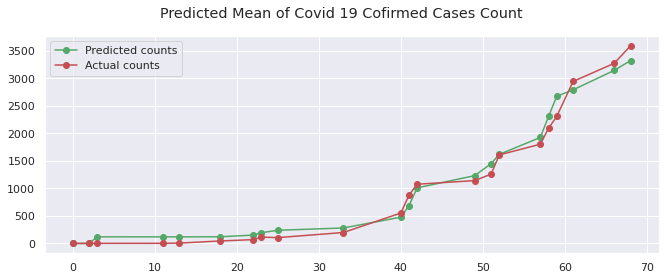

<function mean_squared_error at 0x7f499f1983a0> 30636979641.18022
<function r2_score at 0x7f499f198820> 0.9832682691606534
<function median_absolute_error at 0x7f499f1985e0> 136588.68346563407
<function mean_absolute_error at 0x7f499f198280> 143987.91232388085


In [467]:
predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: 
    print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

## NEW CASES

# Data not normalised

Training data set length=57
Testing data set length=13
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3239.3
Date:                Mon, 18 May 2020   Deviance:                       6052.9
Time:                        10:10:14   Pearson chi2:                 6.10e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

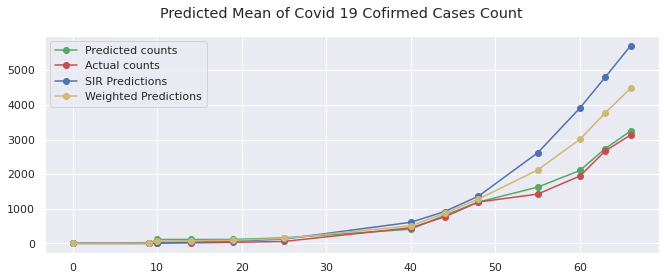

<function mean_squared_error at 0x7f499f1983a0> 9783.963686250001
<function r2_score at 0x7f499f198820> 0.9911996579401497
<function median_absolute_error at 0x7f499f1985e0> 85.38476532893401
<function mean_absolute_error at 0x7f499f198280> 79.01505488530194


In [468]:
expressions = [ expr0]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.8, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results_1(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_cases', 'I_x')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [459]:
for i in rmse.keys():
    print(i, rmse[i])

In [455]:
for i in mae.keys():
    print(i, mae[i])

 new_cases ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt 156.76758819143288
 new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index 73.13554817425388
 new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt 154.92611556241872


In [456]:
for i in r2_Score.keys():
    print(i, r2_Score[i])

 new_cases ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt 0.9770433161203143
 new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index 0.9910351822341469
 new_cases ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt 0.9768506729374297


In [457]:
print('Root Mean_Squared_Error')
print(np.sqrt(mean_squared_error(India[India['new_cases']>0].new_cases, India[India['new_cases']>0].I_x)))
print('R2_Score')
print(r2_score(India[India['new_cases']>0].new_cases, India[India['new_cases']>0].I_x))
print('Mean_Absolute_Error')
mean_absolute_error(India[India['new_cases']>0].new_cases, India[India['new_cases']>0].I_x)

Root Mean_Squared_Error
822.0958008078591
R2_Score
0.5159206578534716
Mean_Absolute_Error


454.74632147335404

## Normalised Data

Training data set length=48
Testing data set length=22
                 Generalized Linear Model Regression Results                  
Dep. Variable:             norm_cases   No. Observations:                   48
Model:                            GLM   Df Residuals:                       43
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38.639
Date:                Sun, 17 May 2020   Deviance:                       4.6416
Time:                        21:38:59   Pearson chi2:                     4.56
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

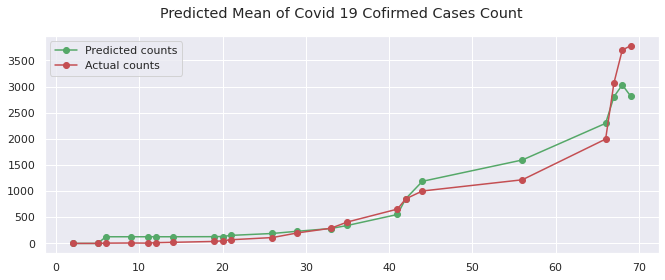

<function mean_squared_error at 0x7f499f1983a0> 82655.64978803076
<function r2_score at 0x7f499f198820> 0.9421116009065547
<function median_absolute_error at 0x7f499f1985e0> 104.73182857330676
<function mean_absolute_error at 0x7f499f198280> 176.49901466225478
Training data set length=51
Testing data set length=19
                 Generalized Linear Model Regression Results                  
Dep. Variable:             norm_cases   No. Observations:                   51
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40.552
Date:                Sun, 17 May 2020   Deviance:                       3.9688
Time:                        21:38:59   Pearson chi2:                     4.03
No. Iterations:                     6               

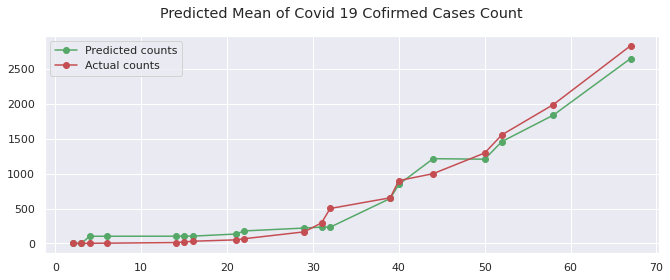

<function mean_squared_error at 0x7f499f1983a0> 13739.611699995268
<function r2_score at 0x7f499f198820> 0.9780150920777498
<function median_absolute_error at 0x7f499f1985e0> 88.63619002607311
<function mean_absolute_error at 0x7f499f198280> 95.95614085980763
Training data set length=56
Testing data set length=14
                 Generalized Linear Model Regression Results                  
Dep. Variable:             norm_cases   No. Observations:                   56
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44.293
Date:                Sun, 17 May 2020   Deviance:                       5.2574
Time:                        21:38:59   Pearson chi2:                     5.36
No. Iterations:                     6                

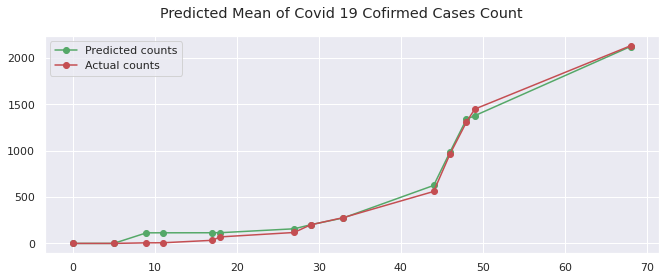

<function mean_squared_error at 0x7f499f1983a0> 3162.3572780696704
<function r2_score at 0x7f499f198820> 0.9927574910246495
<function median_absolute_error at 0x7f499f1985e0> 35.17202928571006
<function mean_absolute_error at 0x7f499f198280> 41.64813446156277


In [151]:
expressions = [norm_expr, norm_expr0, norm_expr1]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)*np.std(India['new_cases'])
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0)*np.std(India['new_cases']), India, 'norm_cases')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

## New Deaths

Training data set length=45
Testing data set length=25
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   45
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -200.42
Date:                Sun, 17 May 2020   Deviance:                       227.14
Time:                        21:39:00   Pearson chi2:                     241.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

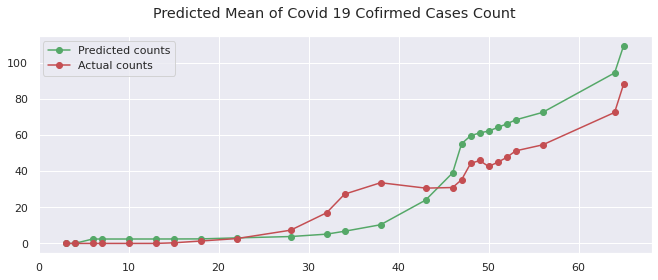

<function mean_squared_error at 0x7f499f1983a0> 191.50753693744096
<function r2_score at 0x7f499f198820> 0.6975225461107777
<function median_absolute_error at 0x7f499f1985e0> 11.86011404379527
<function mean_absolute_error at 0x7f499f198280> 10.964538712692088
Training data set length=54
Testing data set length=16
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   54
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -233.64
Date:                Sun, 17 May 2020   Deviance:                       262.91
Time:                        21:39:00   Pearson chi2:                     285.
No. Iterations:                     6               

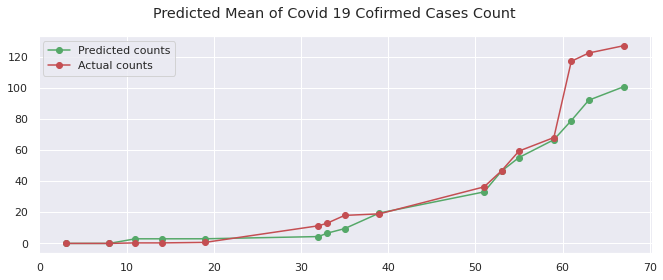

<function mean_squared_error at 0x7f499f1983a0> 204.65931214407038
<function r2_score at 0x7f499f198820> 0.8972277631405867
<function median_absolute_error at 0x7f499f1985e0> 2.9366621035322797
<function mean_absolute_error at 0x7f499f198280> 8.35656832738646
Training data set length=48
Testing data set length=22
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   48
Model:                            GLM   Df Residuals:                       41
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.49
Date:                Sun, 17 May 2020   Deviance:                       284.36
Time:                        21:39:01   Pearson chi2:                     301.
No. Iterations:                     6                

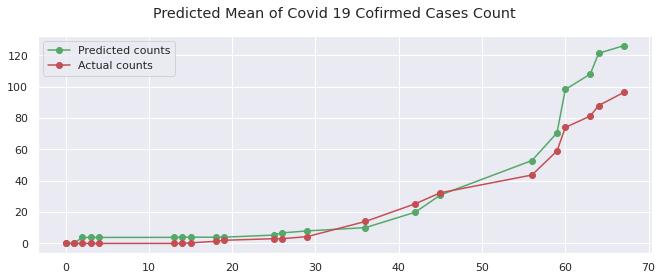

<function mean_squared_error at 0x7f499f1983a0> 168.35453796800834
<function r2_score at 0x7f499f198820> 0.8440957545990606
<function median_absolute_error at 0x7f499f1985e0> 3.813064820093489
<function mean_absolute_error at 0x7f499f198280> 8.313455274834352


In [152]:
expressions = [expr2, expr3, expr4]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_deaths')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [153]:
for i in rmse.keys():
    print(i,': ', round(rmse[i],4))

 new_deaths ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt :  13.8386
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index :  14.3059
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt :  12.9752


In [154]:
for i in mae.keys():
    print(i, round(mae[i],4))

 new_deaths ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt 10.9645
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index 8.3566
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt 8.3135


In [155]:
for i in r2_Score.keys():
    print(i, round(r2_Score[i]))

 new_deaths ~ tests_per_thous + lagged_gov_pol_index + Xt + Rt 1.0
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index 1.0
 new_deaths ~ I_x + Stages + tests_per_thous + lagged_gov_pol_index  +Xt +Rt 1.0


## Predicting for Future

## STEP 1: TEST-TRAIN SPLIT

In [413]:
expr1 = """ new_cases ~ Stages + tests_per_thous + lagged_gov_pol_index """
expr2 = """ new_cases ~ I_x + Rt + lagged_gov_pol_index + logXt """
expr3 = """new_cases ~ Stages + lagged_gov_pol_index """

In [414]:
India_filtered = India_norm.fillna(0)

In [415]:
India_filtered['logXt'] = np.log(India_filtered.Xt)
India_filtered['logIx'] = np.log(India_filtered.I_x)

In [416]:
X_train, y_train, X_test, y_test = train_test_future_split(India_filtered, expr2) 
#X_India, y_India, p, q = train_test_split(India,1, expr4)

Training data set length=70
Testing data set length=218


In [417]:
len(X_test)

218

## STEP 2: MODEL TRAINING AND SUMMARY

In [418]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   70
Model:                            GLM   Df Residuals:                       65
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1324.0
Date:                Mon, 18 May 2020   Deviance:                       2129.4
Time:                        09:56:01   Pearson chi2:                 2.19e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.3625 

## STEP 3: PREDICTIONS

In [426]:
predictions_frame = (predict(model, X_test)).rolling(7).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

             mean       mean_se  mean_ci_lower  mean_ci_upper
0    5.970187e-01  5.693718e-02   4.952330e-01   7.197246e-01
1    6.584344e+00  3.747634e-01   5.889309e+00   7.361404e+00
2    7.482193e+00  4.110002e-01   6.718496e+00   8.332701e+00
3    5.833395e+00  3.431986e-01   5.198072e+00   6.546369e+00
4    8.030952e+00  4.324615e-01   7.226539e+00   8.924906e+00
..            ...           ...            ...            ...
213  1.830050e-18  5.579317e-18   4.649273e-21   7.203456e-16
214  1.601909e-18  4.883957e-18   4.068782e-21   6.306832e-16
215  1.400372e-18  4.269617e-18   3.556314e-21   5.514250e-16
216  1.222512e-18  3.727405e-18   3.104297e-21   4.814409e-16
217  1.065749e-18  3.249469e-18   2.706081e-21   4.197291e-16

[218 rows x 4 columns]


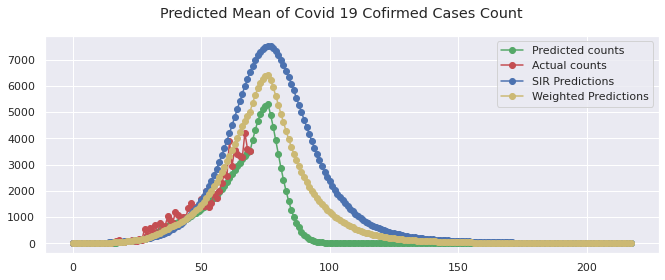

In [427]:
predicted_counts, actual_counts = plot_results_1(predictions_frame,X_test, y_test.rolling(7).mean().fillna(0), India, 'new_cases', 'I_x')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: {}
    #print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))